# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [3]:
import numpy as np
import pandas as pd

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [4]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

35.035324618740702

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [5]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.967996289599814

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [59]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [87]:
x = np.random.exponential(size=sample_size)

In [88]:
x_ = np.random.uniform(-1, 1, sample_size)

In [89]:
y = f(x) + x_

In [90]:
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [91]:
from sklearn import tree
reg = tree.DecisionTreeRegressor()
reg.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [92]:
linspace = linspace.reshape(-1, 1)
linspace.shape

(1000, 1)

In [93]:
y_pred = reg.predict(linspace)

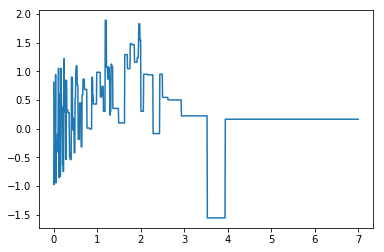

In [95]:
plt.plot(linspace, y_pred)

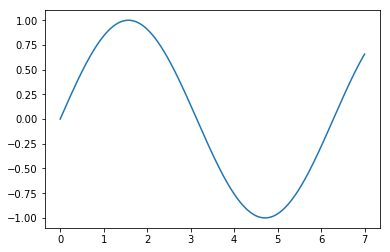

In [96]:
plt.plot(linspace, f(linspace))

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

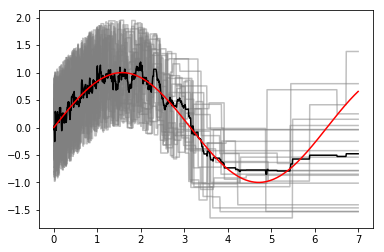

In [106]:
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = tree.DecisionTreeRegressor()
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

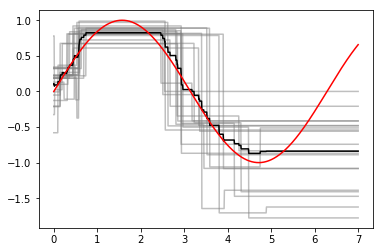

In [107]:
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = tree.DecisionTreeRegressor(max_depth = 2)
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

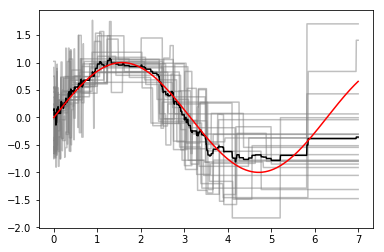

In [108]:
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = tree.DecisionTreeRegressor(max_depth = 4)
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Можно сделать вывод, что чем больше глубина дерева, тем меньше смещение, однако разброс при этом увеличивается. Данный факт отчетливо заметен на графиках выше. При прогоне деревьев без установки параметров максимальная глубина устанавливается в ходе обучения. То есть деревья строятся до того, пока в листе не останутся объекты из одного класса, или пока в листе не будет минимально допустимое количество объектов. Следовательно, можно утверждать, что деревья без ограничений на глбину глубже (как не парадоксально). Можно увидеть, что с уменьшением глубины величина смещения увеличивается. Следовательно, смещение близко к нулю в случае отсутствия ограничений на глубину. Наибольшее смещение в случае глубины, равной 2. 

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

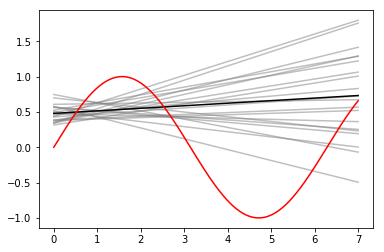

In [110]:
from sklearn.linear_model import LinearRegression
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

На графике видно, что линейная регрессия восстанавливает исключительно линейные зависимости. Следовательно, наблюдается большая величина как разброса, так и смещения.

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


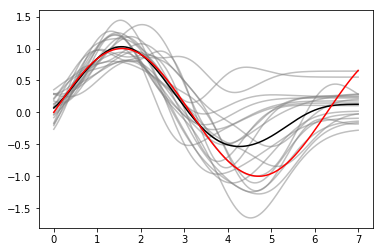

In [112]:
from sklearn import svm
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = svm.SVR(kernel = 'rbf', gamma = 1)
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


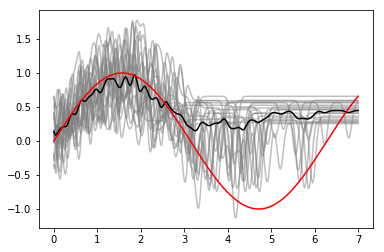

In [113]:
from sklearn import svm
y_pred_mean = 0
for i in range(samples_num):
    x = np.random.exponential(size=sample_size)
    x_ = np.random.uniform(-1, 1, sample_size)
    y = f(x) + x_
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    reg = svm.SVR(kernel = 'rbf', gamma = 100)
    reg.fit(x, y)
    y_pred = reg.predict(linspace)
    y_pred_mean += y_pred
    plt.plot(linspace, y_pred, color="gray", alpha=0.5)
y_pred_mean = y_pred_mean/samples_num
y_pred_mean = y_pred_mean.reshape(-1, 1)
plt.plot(linspace, y_pred_mean, color = 'black')
plt.plot(linspace, f(linspace), color = 'red')

При параметре $\gamma = 1$ наблюдаются маленькие смещение и разброс. При увелечении данного параметра разброс остается примерно таким же, тогда как смещение начинает расти. Кроме того, на графике видно, что возникает проблема переобучения (при $\gamma = 100$). Следовательно, меньшие значения изменяющегося параметра лучше восстанавливают зависимость на тестовой выборке (особенно хорошо удается это сделать при малых значениях _x_).

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

Будем преобразовывать данные постепенно. Сначала выгрузим данные.

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [6]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header = None)
tic_rac = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header = None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header = None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header = None)

In [7]:
nursery

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
7,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom


### Mushrooms

В данном датасете все признаки являются категориальными. Следовательно, преобразуем их с помощью _LabelEncoder_, чтобы все признаки воспринимались как вещественные. Далее с помощью _get dummies_ преобразуем их так, будто они все категориальные (а они и есть все категориальные). Так же не забудем вывести зависимую переменную. 

In [294]:
mushrooms_y = mushrooms[0]
mushrooms_x = mushrooms.drop(0, 1)

In [295]:
mushrooms_x_dummies = pd.get_dummies(mushrooms_x)

In [296]:
le = LabelEncoder()
le.fit(mushrooms_y)
mushrooms_y = le.transform(mushrooms_y)

In [297]:
for i in range(1, len(mushrooms_x.columns)+1):
    mushrooms_x[i] = le.fit_transform(mushrooms_x[i])

### Tic_rac

Для данного датасета проделаем такие же шаги, так как все переменные так же являются категориальными.

In [298]:
tic_rac_y = tic_rac[9]
tic_rac_x = tic_rac.drop(9, 1)

In [299]:
le.fit(tic_rac_y)
tic_rac_y = le.transform(tic_rac_y)

In [300]:
tic_rac_x_dummies = pd.get_dummies(tic_rac_x)

In [301]:
for i in range(0, len(tic_rac_x.columns)):
    tic_rac_x[i] = le.fit_transform(tic_rac_x[i])

### Cars

В данном датасете будет необходим более глубокий анализ. Во-первых, признаки представляют собой упорядоченный категориальнй признак. Поэтому, так как _LabelEncoder_ сортирует классы по алфавиту, признаки будут преобразованы вручную. Для восприятия их как категориальные, будет использовано _get dummies_, как вещественные - _LabelEncoder_, как правильно разбитые - ручное разбиение.

In [302]:
cars_y = cars[6]
cars_x = cars.drop(6, 1)

In [303]:
cars_y[cars_y.isin(['acc', 'unacc'])] = 0
cars_y[cars_y.isin(['good', 'vgood'])]= 1

In [304]:
cars_x_norm = cars_x.copy()
cars_x_norm[cars_x_norm == 'low'] = 0
cars_x_norm[cars_x_norm == 'small'] = 0
cars_x_norm[cars_x_norm == 'med'] = 1
cars_x_norm[cars_x_norm == 'high'] = 2
cars_x_norm[cars_x_norm == 'big'] = 2
cars_x_norm[cars_x_norm == 'vhigh'] = 3
cars_x_norm[cars_x_norm == 'more'] = 5
cars_x_norm[cars_x_norm == '5more'] = 5

In [305]:
cars_x_dummies = pd.get_dummies(cars_x)

In [306]:
for i in range(len(cars_x.columns)):
    cars_x[i] = le.fit_transform(cars_x[i])

### Nursery

В данном датасете так же необходим более глубокий анализ. Проделанные шаги будут аналогичны тем, что были сделаны с датасетом _cars_. 

In [307]:
nursery_y = nursery[8]
nursery_x = nursery.drop(8, 1)

In [308]:
nursery_y[nursery_y.isin(['not_recom', 'recommend'])] = 0
nursery_y[nursery_y.isin(['very_recom', 'priority', 'spec_prior'])] = 1

- parents:     usual, pretentious, great_pret. [0]
- has_nurs:    proper, less_proper, improper, critical, very_crit. [1]
- form:        complete, completed, incomplete, foster. [2]
- children:    1, 2, 3, more. [3]
- housing:     convenient, less_conv, critical. [4]
- finance:     convenient, inconv. [5]
- social:      nonprob, slightly_prob, problematic. [6]
- health:      recommended, priority, not_recom. [7]

In [309]:
nursery_x_norm = nursery_x.copy()
nursery_x_norm[0][nursery_x_norm[0] == 'usual'] = 0
nursery_x_norm[0][nursery_x_norm[0] == 'pretentious'] = 1
nursery_x_norm[0][nursery_x_norm[0] == 'great_pret'] = 2
nursery_x_norm[1][nursery_x_norm[1] == 'very_crit'] = 0
nursery_x_norm[1][nursery_x_norm[1] == 'critical'] = 1
nursery_x_norm[1][nursery_x_norm[1] == 'improper'] = 2
nursery_x_norm[1][nursery_x_norm[1] == 'less_proper'] = 3
nursery_x_norm[1][nursery_x_norm[1] == 'proper'] = 4
nursery_x_norm[2][nursery_x_norm[2] == 'complete'] = 0
nursery_x_norm[2][nursery_x_norm[2] == 'completed'] = 1
nursery_x_norm[2][nursery_x_norm[2] == 'incomplete'] = 2
nursery_x_norm[2][nursery_x_norm[2] == 'foster'] = 3
nursery_x_norm[3][nursery_x_norm[3] == 'more'] = 4
nursery_x_norm[4][nursery_x_norm[4] == 'critical'] = 0
nursery_x_norm[4][nursery_x_norm[4] == 'less_conv'] = 1
nursery_x_norm[4][nursery_x_norm[4] == 'convenient'] = 2
nursery_x_norm[5][nursery_x_norm[5] == 'inconv'] = 0
nursery_x_norm[5][nursery_x_norm[5] == 'convenient'] = 1
nursery_x_norm[6][nursery_x_norm[6] == 'problematic'] = 0
nursery_x_norm[6][nursery_x_norm[6] == 'slightly_prob'] = 1
nursery_x_norm[6][nursery_x_norm[6] == 'nonprob'] = 2
nursery_x_norm[7][nursery_x_norm[7] == 'not_recom'] = 0
nursery_x_norm[7][nursery_x_norm[7] == 'recommended'] = 1
nursery_x_norm[7][nursery_x_norm[7] == 'priority'] = 2

In [310]:
nursery_x_dummies = pd.get_dummies(nursery_x)

In [311]:
for i in range(len(nursery_x.columns)):
    nursery_x[i] = le.fit_transform(nursery_x[i])

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Есть подозрение, что некоторые датасеты отсортированы. Поэтому будем использовать shufflesplit с 10 разбиениями, для получения более точных результатов (вместо cv = 10). 

In [11]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [329]:
cv = ShuffleSplit(n_splits= 10, test_size=0.3, random_state=42)

### Mushrooms

In [330]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=mushrooms_x_dummies, y = mushrooms_y, cv = cv).mean()

1.0

In [331]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=mushrooms_x, y = mushrooms_y, cv = cv).mean()

1.0

В обоих случаях получился отличный результат. По логике вещей, при сортировке признаков как категориальные (через дамми), результат должен был быть лучше. 

### Tic_rac

In [332]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=tic_rac_x_dummies, y = tic_rac_y, cv = cv).mean()

0.92743055555555554

In [333]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score), X=tic_rac_x, y = tic_rac_y, cv = cv).mean()

0.87708333333333344

Если алгоритм воспринимает все признаки как категориальные, получается более хороший результат. Это логично, так как все признаки являются категориальными.


### Cars

In [345]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(cars_x_dummies, dtype = 'int'), y = np.array(cars_y, dtype = 'int'), cv = cv).mean()

0.98516377649325637

In [346]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(cars_x, dtype = 'int'), y = np.array(cars_y, dtype = 'int'), cv = cv).mean()

0.98940269749518317

In [347]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(cars_x_norm, dtype = 'int'), y = np.array(cars_y, dtype = 'int'), cv = cv).mean()

0.99113680154142558

В этом случае самый хороший результат получился при ручном разбиении выборки. Разбиение через _LabelEncoder_ дало худшие результаты. 

### Nursery

In [348]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(nursery_x_dummies, dtype = 'int'), y = np.array(nursery_y, dtype = 'int'), cv = cv).mean()

0.99981995884773656

In [349]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(nursery_x, dtype = 'int'), y = np.array(nursery_y, dtype = 'int'), cv = cv).mean()

0.99974279835390933

In [350]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X=np.array(nursery_x_norm, dtype = 'int'), y = np.array(nursery_y, dtype = 'int'), cv = cv).mean()

0.99984567901234578

Аналогично лучший результат вышел при корректном разбиении выборки.

Так как в данном пункте просят использовать кросс-валидацию, то случайная компонента начинает играть важную роль. Если не перемешать выборки перед обучением алгоритмов, возможна ситуация, когда разбиение выборок будет давать слишком низкий результат, даже при кросс валидации равной 10. Поэтому разбивать выборки на основе каких-нибудь признаков не рекомендуется во избежание получения плохих результатов. 

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [56]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [57]:
df_7 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
y_7 = df_7['quality']
x_7 = df_7.drop('quality', 1)

In [58]:
cross_val_score(estimator = DecisionTreeClassifier(), scoring = make_scorer(accuracy_score),\
                X = x_7, y = y_7, cv = 3).mean()

0.45155534897414795

In [59]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),\
                X = x_7, y = y_7, cv = 3).mean()

0.56602633144650583

In [60]:
cross_val_score(estimator = BaggingClassifier(n_estimators = 100, max_features = 0.5), scoring = make_scorer(accuracy_score),\
                X = x_7, y = y_7, cv = 3).mean()

0.54857153216404153

In [61]:
cross_val_score(estimator = RandomForestClassifier(n_estimators = 100), scoring = make_scorer(accuracy_score),\
                X = x_7, y = y_7, cv = 3).mean()

0.56607785351879036

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [62]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [63]:
X_7, Y_7 = shuffle(x_7, y_7, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_7, Y_7, test_size = 0.3, random_state = 42)

In [64]:
clf = RandomForestClassifier(warm_start = True, random_state = 42)

In [65]:
score = []
x_axis = []
a = 100
for i in range(50):
    clf.set_params(n_estimators = a)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score.append(accuracy_score(y_test, y_pred))
    x_axis.append(a)
    a += 100

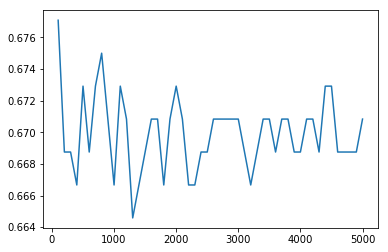

In [66]:
plt.plot(x_axis, score)

Значение метрики снижается при большом количестве деревьев, что свидетельствует о переобучении.

__Ответ: Да__

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [18]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

Sources: 

https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [19]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import np_utils

In [20]:
X_train = x_train.reshape(60000, 784)
X_test = x_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [54]:
model = Sequential()

model = Sequential()
model.add(Dense(512, input_shape=(784,), activation = 'relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [55]:
model.fit(x=X_train, y=Y_train, batch_size=128, epochs = 12, verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 12s 202us/step - loss: 0.3324 - acc: 0.9053 - val_loss: 0.1810 - val_acc: 0.9457
Epoch 2/12
60000/60000 [==============================] - 12s 207us/step - loss: 0.1271 - acc: 0.9629 - val_loss: 0.1157 - val_acc: 0.9635
Epoch 3/12
60000/60000 [==============================] - 12s 206us/step - loss: 0.0880 - acc: 0.9741 - val_loss: 0.0896 - val_acc: 0.9714
Epoch 4/12
60000/60000 [==============================] - 13s 209us/step - loss: 0.0659 - acc: 0.9803 - val_loss: 0.0723 - val_acc: 0.9781
Epoch 5/12
60000/60000 [==============================] - 13s 216us/step - loss: 0.0515 - acc: 0.9849 - val_loss: 0.0674 - val_acc: 0.9796
Epoch 6/12
60000/60000 [==============================] - 13s 215us/step - loss: 0.0407 - acc: 0.9880 - val_loss: 0.0669 - val_acc: 0.9791
Epoch 7/12
60000/60000 [==============================] - 9s 146us/step - loss: 0.0316 - acc: 0.9912 - val_loss: 0.0

На тесте точность принимает значение 0.9764 на тестовой выборке на последней эпохе. 

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [21]:
if K.image_data_format() == 'channels_first':
    X_train_10 = x_train.reshape(x_train.shape[0], 1, 28, 28)
    X_test_10 = x_test.reshape(x_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train_10 = x_train.reshape(x_train.shape[0], 28, 28, 1)
    X_test_10 = x_test.reshape(x_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

X_train_10 = X_train_10.astype('float32')
X_test_10 = X_test_10.astype('float32')
X_train_10 /= 255
X_test_10 /= 255
print('X_train_10 shape:', X_train_10.shape)
print(X_train_10.shape[0], 'train samples')
print(X_test_10.shape[0], 'test samples')

X_train_10 shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [26]:
model.fit(X_train_10, Y_train, batch_size=16, epochs=4, verbose=1, validation_data=(X_test_10, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 468s 8ms/step - loss: 0.0716 - acc: 0.9783 - val_loss: 0.0513 - val_acc: 0.9834
Epoch 2/4
60000/60000 [==============================] - 467s 8ms/step - loss: 0.0411 - acc: 0.9877 - val_loss: 0.0354 - val_acc: 0.9887
Epoch 3/4
60000/60000 [==============================] - 482s 8ms/step - loss: 0.0302 - acc: 0.9909 - val_loss: 0.0362 - val_acc: 0.9890
Epoch 4/4
60000/60000 [==============================] - 476s 8ms/step - loss: 0.0230 - acc: 0.9930 - val_loss: 0.0281 - val_acc: 0.9913


При 12 эпохах и батч сайзе 128 получалась точность: 0.9905

При 4 эпохах и батч сайзе 16 получилась точность: 0.9913

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [6]:
model.fit(X_train_10, Y_train, batch_size=128, epochs=12, verbose=1, validation_data=(X_test_10, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 265s 4ms/step - loss: 0.3218 - acc: 0.9022 - val_loss: 0.0715 - val_acc: 0.9784
Epoch 2/12
60000/60000 [==============================] - 277s 5ms/step - loss: 0.1084 - acc: 0.9679 - val_loss: 0.0525 - val_acc: 0.9837
Epoch 3/12
60000/60000 [==============================] - 281s 5ms/step - loss: 0.0824 - acc: 0.9757 - val_loss: 0.0433 - val_acc: 0.9861
Epoch 4/12
60000/60000 [==============================] - 295s 5ms/step - loss: 0.0693 - acc: 0.9798 - val_loss: 0.0356 - val_acc: 0.9876
Epoch 5/12
60000/60000 [==============================] - 287s 5ms/step - loss: 0.0618 - acc: 0.9817 - val_loss: 0.0336 - val_acc: 0.9886
Epoch 6/12
60000/60000 [==============================] - 284s 5ms/step - loss: 0.0572 - acc: 0.9829 - val_loss: 0.0346 - val_acc: 0.9872
Epoch 7/12
60000/60000 [==============================] - 263s 4ms/step - loss: 0.0514 - acc: 0.9848 - val_loss: 0.0312 - 

В целом точность на тестовой выборке остается примерно на таком же уровне, поэтому качество модели остается примерно таким же. С процессом обучения все нормально, но дольше чем без дропаута. 

Точность: 0.9903